# DL_HW3

In [1]:
import numpy as np
import pandas as pd
import os, cv2, time
from imageio import imread, imwrite
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
# from .autonotebook import tqdm as notebook_tqdm
import multiprocessing
from multiprocessing import Pool


In [2]:
cpus = multiprocessing.cpu_count()
print(cpus)
# print(torch.cuda.is_available()) 

160


## Read Data

In [3]:
# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

In [4]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = np.array(pd.read_table('train.txt', header = None, sep = ' '))
val_idx = np.array(pd.read_table('val.txt', header = None, sep = ' '))
test_idx = np.array(pd.read_table('test.txt', header = None, delimiter = ' '))
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
train_onehot_y = self_onehot(train_y)
val_onehot_y = self_onehot(val_y)
test_onehot_y = self_onehot(test_y)
with Pool(processes = 80) as p:
    train_pic = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
    val_pic = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
    test_pic = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
    
train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

os.chdir('/home/rita/111/111-2DL/HW3')

100%|██████████| 450/450 [00:00<00:00, 1019.44it/s]


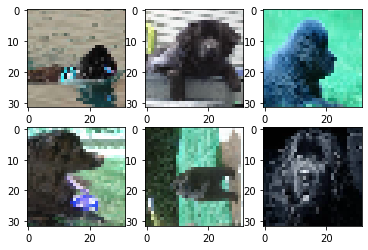

In [5]:
# print img
plt.subplot(2, 3, 1)
img = Image.fromarray(train_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 2)
img = Image.fromarray(val_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 3)
img = Image.fromarray(test_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 4)
img = Image.fromarray(train_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 5)
img = Image.fromarray(val_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 6)
img = Image.fromarray(test_pic[1].astype(np.uint8))
plt.imshow(img)

## Tensorflow.Keras Lenet5

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
# import tensorflow.compat.v1 as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.2


In [7]:
# test on 50 figure
# https://zhuanlan.zhihu.com/p/134149111

# tf.enable_eager_execution()
def preprocess(x, y):
    # tf.cast : Casts a tensor to a new type.
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 32, 32, 3])
    y = tf.one_hot(y, depth=50)  # one_hot 编码
    return x, y

batch_size = 32
# 加载数据集
x_train, y_train, x_test, y_test = train_pic.astype(np.uint8), train_y.astype(np.uint8),  test_pic.astype(np.uint8), test_y.astype(np.uint8)
x_val, y_val = val_pic.astype(np.uint8), val_y.astype(np.uint8)

train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(10000)  # 打乱训练集样本
train_db = train_db.batch(batch_size)
train_db = train_db.map(preprocess)

val_db = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_db = val_db.shuffle(10000)  # 打乱训练集样本
val_db = val_db.batch(batch_size)
val_db = val_db.map(preprocess)

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(10000)  # 打乱测试集样本
test_db = test_db.batch(batch_size)
test_db = test_db.map(preprocess)

In [8]:
# 创建模型
model = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(6, 5),  # 使用6个5*5的卷积核对单通道32*32的图片进行卷积，结果得到6个28*28的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对28*28的特征图进行2*2最大池化，得到14*14的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层2
    keras.layers.Conv2D(16, 5),  # 使用16个5*5的卷积核对6通道14*14的图片进行卷积，结果得到16个10*10的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对10*10的特征图进行2*2最大池化，得到5*5的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层3
    keras.layers.Conv2D(120, 5),  # 使用120个5*5的卷积核对16通道5*5的图片进行卷积，结果得到120个1*1的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 将 (None, 1, 1, 120) 的下采样图片拉伸成 (None, 120) 的形状
    keras.layers.Flatten(),
    # 全连接层1
    keras.layers.Dense(84, activation='relu'),  # 120*84
    # 全连接层2
    keras.layers.Dense(50, activation='softmax')  # 84*10
])
model.build(input_shape=(None, 32, 32, 3))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
re_lu_4 (ReLU)               (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)        

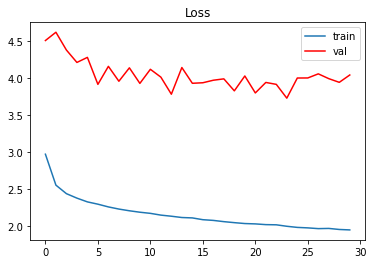

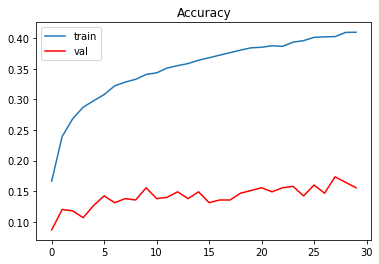

In [29]:
# %load_ext line_profiler

# @profile(precision=4, stream=open('./memory/memory_profiler_keras.log','w+'))
batch_size = 32

model.build(input_shape=(batch_size, 32, 32, 3))
model.summary()

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# 训练
history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)

model.save('./model/keras_Lenet5')

# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val", c = 'red')
plt.legend()
plt.savefig('./figure/keras_cnn_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val", c = 'red')
plt.legend()
plt.savefig('./figure/keras_cnn_acc.png')
plt.show()


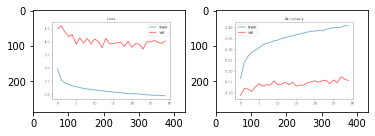

In [9]:
plt.subplot(1, 2, 1)
img = imread('./figure/keras_cnn_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./figure/keras_cnn_acc.png')
plt.imshow(img)

### Compare

In [14]:
import timeit, time
# https://pypi.org/project/keras-flops/
from keras_flops import get_flops


In [15]:
loaded_model = keras.models.load_model('./model/keras_Lenet5')
# loaded_model.summary()
@tf.function
def model_static(x, y):
    y_pred = loaded_model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss
def model_dynamic(x, y):
    y_pred = loaded_model(x)
    loss = tf.losses.MeanSquaredError()(y_pred, y)
    return y_pred, loss
static_infer = timeit.timeit(lambda: model_static(x_test, test_onehot_y), number = 10)
dynamic_infer = timeit.timeit(lambda: model_dynamic(x_test, test_onehot_y), number = 10)

print('static graph Inference Time:', static_infer)
print('dynamic graph Inference Time:', dynamic_infer)

# @tf.function
# def model_static(loaded_model, train_db, val_db, batch_size = 32):
#     loaded_model.build(input_shape=(batch_size, 32, 32, 3))
#     loaded_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#     history = loaded_model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)
#     # return y_pred, loss
# def model_dynamic(loaded_model, train_db, val_db, batch_size = 32):
#     loaded_model.build(input_shape=(batch_size, 32, 32, 3))
#     loaded_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#     history = loaded_model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)
#     # return y_pred, loss
# static_train = timeit.timeit(lambda: model_static(loaded_model, train_db, val_db), number = 10)
# dynamic_train = timeit.timeit(lambda: model_dynamic(loaded_model, train_db, val_db), number = 10)

# print('static graph Inference Time:', static_train)
# print('dynamic graph Inference Time:', dynamic_train)

static graph Inference Time: 0.13061565696261823
dynamic graph Inference Time: 0.04927386099006981


In [12]:
# temp = pd.DataFrame(columns = ['Static', 'Dynamic'], index = ['Inference Time', 'Training Time'])
# temp.to_csv('static_dynamic.csv')
time_start = time.perf_counter()
model.build(input_shape=(batch_size, 32, 32, 3))
model.summary()

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# 训练
history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)

static_train = time.perf_counter() - time_start

temp = pd.read_csv('static_dynamic.csv', index_col = [0])
temp.at['Inference Time', 'Static'] = static_infer
temp.at['Inference Time', 'Dynamic'] = dynamic_infer
temp.at['Training Time', 'Dynamic'] = static_train
print(temp)
temp.to_csv('static_dynamic.csv')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         4

In [17]:
# https://pypi.org/project/keras-flops/

loaded_model = keras.models.load_model('./model/keras_Lenet5')
loaded_model.summary()

# inference time
time_start = time.perf_counter()
loss, acc_test = loaded_model.evaluate(test_db)
t = time.perf_counter() - time_start
print("Time for Keras Lenet : {} s".format(t))

# Accuracy
print('Accuracy for Keras Lenet : ', acc_test)
print('Loss for Keras Lenet : ', loss)
loss, acc_val = loaded_model.evaluate(val_db)

# space complexity
# https://pypi.org/project/model-profiler/
from model_profiler import model_profiler
Batch_size = 32

profile = model_profiler(model, Batch_size, use_units = ['GPU IDs', 'MFLOPs', 'GB', 'Million', 'MB'])
# profile = model_profiler(model, Batch_size)

print(profile)

# Flops
flops = get_flops(model, batch_size=32)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
re_lu_4 (ReLU)               (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)        

/home/rita/miniconda3/envs/369/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Consider rewriting this model with the Functional API.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 0.0423 G


In [28]:
@profile(precision=4, stream=open('./memory/memory_profiler_keras.log','w+'))

def train_lenet(model):
    model.build(input_shape=(batch_size, 32, 32, 3))
    model.summary()

    # model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    # 训练
    history = model.fit(train_db, epochs=30, validation_data = val_db, use_multiprocessing = True)
    return model, history

model, history = train_lenet(model)

ERROR: Could not find file /tmp/ipykernel_1281929/2019920501.py


In [18]:
# temp.to_csv('results.csv')
temp = pd.read_csv('results.csv', index_col = [0])
temp.at['Accuracy Test', 'Keras'] = acc_test
temp.at['Accuracy Val', 'Keras'] = acc_val
temp.at['Inference Time', 'Keras'] = t
temp.at['Space Complexity', 'Keras'] = 0.2495 * 1024
temp.at['FLOPS', 'Keras'] = flops / 10 ** 9
print(temp)
temp.to_csv('results.csv')

                  Scratch     PyTorch       Keras
Accuracy Test         NaN    0.113333    0.173333
Accuracy Val          NaN    0.111111    0.155556
Inference Time        NaN    0.067298    0.239028
Space Complexity      NaN  661.640000  255.488000
FLOPS                 NaN   41.925120    0.042345
